LACOUX Coline <br/>
EL MADAFRITE Saad 

# Projet ML 2020 : Inpainting

In [1]:
import numpy as np
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import matplotlib.pyplot as plt
from sklearn import linear_model

# Partie 1 - Préambule : régression linéaire, régression ridge et LASSO

In [2]:
# TODO : trouver meilleur valeur de alpha pour ridge et lasso, chercher un indice de bonne classification pour comparer les algo

In [3]:
def load_usps(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f if len(l.split())>2] 
        tmp = np.array(data)
    return tmp[: ,1:] ,tmp[: ,0]. astype(int)


In [4]:
datax_train , datay_train = load_usps ("data/USPS_train.txt")
datax_test , datay_test = load_usps ("data/USPS_test.txt")

datay_train = np.where(datay_train > 1 , 1 , -1)
datay_test = np.where(datay_test > 1 , 1 , -1)

In [5]:
linear_reg_model = linear_model.LinearRegression()
linear_reg_model.fit(datax_train, datay_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [6]:
ridge_model = linear_model.Ridge(alpha=10)
ridge_model.fit(datax_train, datay_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [7]:
lasso_model = linear_model.Lasso(alpha=0.1)
lasso_model.fit(datax_train, datay_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

number of non-zeros : 256


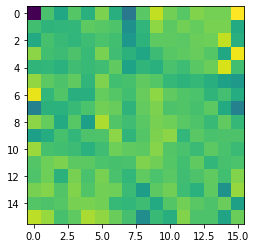

In [8]:
plt.imshow((linear_reg_model.coef_.reshape(16,16)), cmap=plt.cm.viridis )
print("number of non-zeros :", np.count_nonzero(linear_reg_model.coef_) )

number of non-zeros : 256


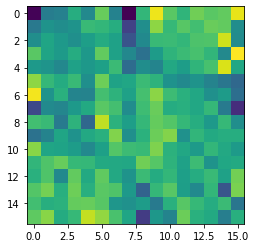

In [9]:
plt.imshow((ridge_model.coef_.reshape(16,16)), cmap=plt.cm.viridis )
print("number of non-zeros :", np.count_nonzero(ridge_model.coef_) )

number of non-zeros : 19


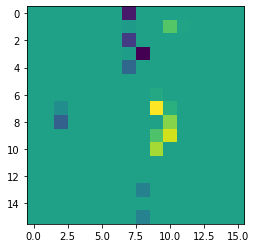

In [10]:
plt.imshow((lasso_model.coef_.reshape(16,16)), cmap=plt.cm.viridis )
print("number of non-zeros :", np.count_nonzero(lasso_model.coef_) )

In [11]:
pred_train = np.where(linear_reg_model.predict(datax_train) >= 0 , 1 , -1) 
pred_test = np.where(linear_reg_model.predict(datax_test) >= 0 , 1 , -1) 

print("Linear regression accuracy on train : ",(pred_train == datay_train).mean())
print("Linear regression accuracy on test  : ",(pred_test  == datay_test).mean())

Linear regression accuracy on train :  0.9668083939103004
Linear regression accuracy on test  :  0.9446935724962631


In [12]:
pred_train = np.where(ridge_model.predict(datax_train) >= 0 , 1 , -1) 
pred_test = np.where(ridge_model.predict(datax_test) >= 0 , 1 , -1) 

print("Ridge regression accuracy on train : ",(pred_train == datay_train).mean())
print("Ridge regression accuracy on test  : ",(pred_test  == datay_test).mean())

Ridge regression accuracy on train :  0.967219860101495
Ridge regression accuracy on test  :  0.9441953163926258


In [13]:
pred_train = np.where(lasso_model.predict(datax_train) >= 0 , 1 , -1) 
pred_test = np.where(lasso_model.predict(datax_test) >= 0 , 1 , -1) 

print("Lasso algorithm accuracy on train : ",(pred_train == datay_train).mean())
print("Lasso algorithm accuracy on test  : ",(pred_test  == datay_test).mean())

Lasso algorithm accuracy on train :  0.9041283774516528
Lasso algorithm accuracy on test  :  0.898355754857997


comparaison : conclusion, lasso selection de features car bcp de poids à 0 (seuls quelque pixels sont pris en comtpe)

# Partie 2 - LASSO et Inpainting

In [275]:
def read_img(filename):
    img = plt.imread(filename)[:,:,0:3]
    img = rgb_to_hsv(img)
    img = -1 + 2*img
    return img

In [276]:
def show_img(img):
    img_to_show = np.where(img == -100, -1, img)
    img_to_show = (1 + img_to_show) / 2
    img_to_show = hsv_to_rgb(img_to_show)
    plt.imshow(img_to_show)
    plt.show()

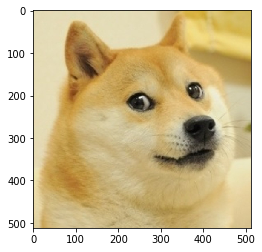

In [277]:
doge = read_img("data/doge.png")
show_img(doge)

In [278]:
def get_patch(i,j,h,img):
    return img[i-h//2:i+h//2:,j-h//2:j+h//2]

In [279]:
def patch_to_vect(patch):
    return patch.ravel()

In [280]:
def vect_to_patch(vect):
    h = int(np.sqrt(vect.size / 3))
    return vect.reshape(h,h,3)

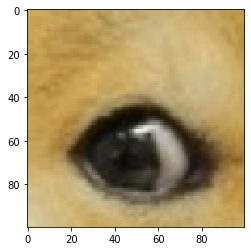

(100, 100, 3)


In [281]:
patch = get_patch(200,250, 100, doge)
show_img(patch)
print(patch.shape)

In [282]:
vect = patch_to_vect(patch)
print(vect.shape)

(30000,)


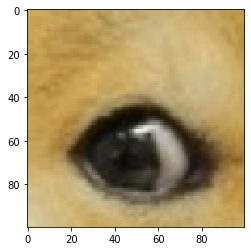

In [283]:
patch = vect_to_patch(vect)
show_img(patch)

In [284]:
def noise(img, prc):
    img_noised = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[0]):
            n = np.random.rand()
            if n < prc :
                img_noised[i,j] = [-100, -100, -100]
    return img_noised

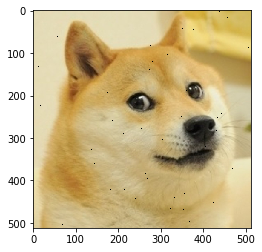

In [285]:
doge_noised = noise(doge, 0.001)
show_img(doge_noised)

In [286]:
def delete_rect(img,i,j,height,width):
    img_del = img.copy()
    img_del[i-height//2:i+height//2:,j-width//2:j+width//2] = -100
    return img_del

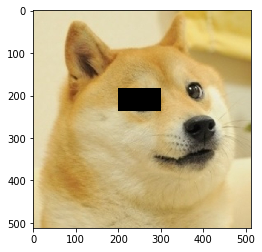

In [287]:
doge_pirate = delete_rect(doge, 210,250, 55,100)
show_img(doge_pirate)

In [288]:
def miss_pixel(patch):
    return np.argwhere(patch == -100).shape[0] > 0

def empty_patch(patch):
    return np.argwhere(patch == -100).shape[0] == patch.size

In [289]:
def atoms_dictionary(img, step):
    dic = {}
    height, width, dim = img.shape
    for i in range(step//2, height-step//2, step):
        for j in range(step, width-step, step):
            patch = get_patch(i, j, step, img)
            #print(patch.shape)
            if not miss_pixel(patch):
                dic[i,j] = patch
    return dic

In [290]:
def noise_dictionary(img, step):
    dic = {}
    height, width, dim = img.shape
    for i in range(step//2, height-step//2, step):
        for j in range(step//2, width-step//2, step):
            patch = get_patch(i, j, step, img)
            if miss_pixel(patch):
                dic[i,j] = patch
    return dic

In [291]:
dic = atoms_dictionary(doge_pirate, 100)

In [292]:
print(len(dic))

16


In [293]:
missing_pixels = noise_dictionary(doge_pirate, 100)
print(len(missing_pixels))

2


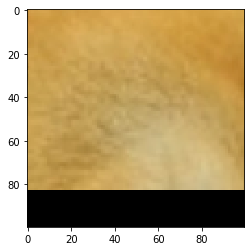

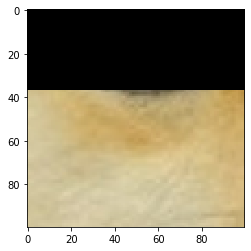

In [294]:
for patch in missing_pixels.values():
    show_img(patch)
    plt.show()

In [320]:
def learn_weigth(patch, dictionary, alpha=0.005):
    lasso_model = linear_model.Lasso(alpha=alpha, max_iter = 50000)
    Y = patch_to_vect(patch)
    train_i = np.argwhere(Y != -100).ravel()
    test_i  = np.argwhere(Y == -100).ravel()
    X = np.empty((patch.size, len(dictionary)))
    i = 0
    for patch_i in dictionary.values():
        X[:,i] = patch_to_vect(patch_i)
        i = i +1
    lasso_model.fit(X[train_i], Y[train_i])
    w = lasso_model.coef_
    
    Y[test_i] = lasso_model.predict(X[test_i])
    return w, vect_to_patch(Y)

2 16


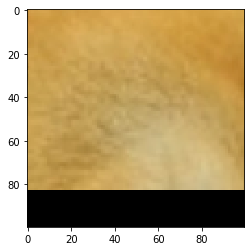

150 250


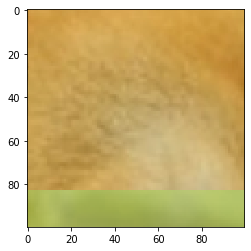

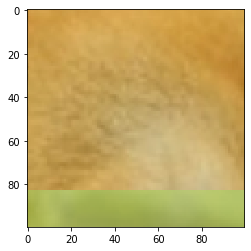

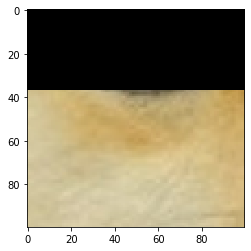

250 250


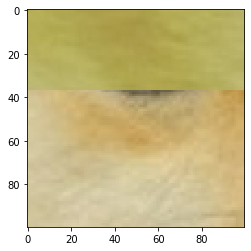

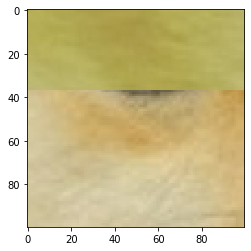

In [296]:
missing_pixels = noise_dictionary(doge_pirate, 100)
dic = atoms_dictionary(doge_pirate,100)
print(len(missing_pixels), len(dic))
doge_borgne = doge_pirate.copy()
for (i,j), patch in missing_pixels.items():
    show_img(patch)
    plt.show()
    print(i,j)
    w, reconstruction_patch = learn_weigth(patch, dic, alpha=0.05)
    show_img(reconstruction_patch)
    replace_patch(doge_borgne, reconstruction_patch, i, j, 100)
    plt.show()

In [297]:
def replace_patch(img, patch, i, j, h):
    img[i-h//2:i+h//2:,j-h//2:j+h//2] = patch


In [298]:
def naive_reconstruction(img, h):
    missing_pixels = noise_dictionary(img, h)
    dic = atoms_dictionary(img,h)
    rec = img.copy()
    for (i,j), patch in missing_pixels.items():
        if not empty_patch(patch):
            w, new_patch = learn_weigth(patch, dic)
            replace_patch(rec, new_patch, i, j, h)
    return rec

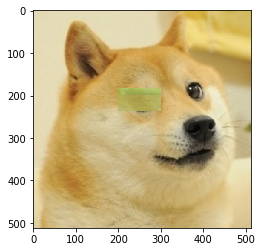

In [299]:
show_img(doge_borgne)

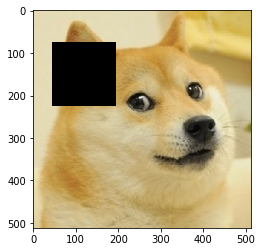

In [300]:
doge_rectangle = delete_rect(doge, 150,120, 150,150)

show_img(doge_rectangle)

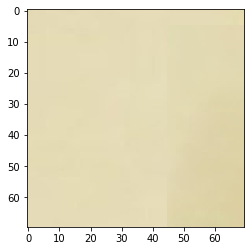

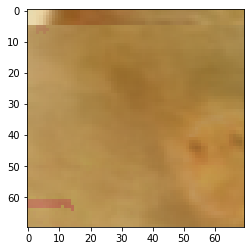

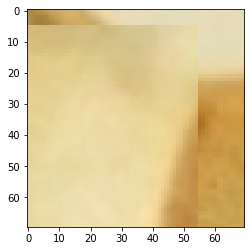

/Users/colinelacoux/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46114799160913966, tolerance: 0.449985693991649
  positive)


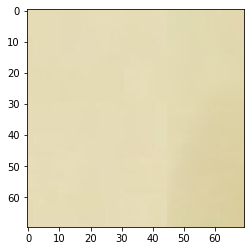

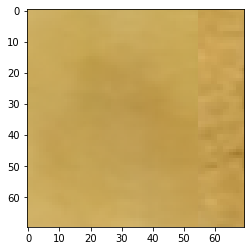

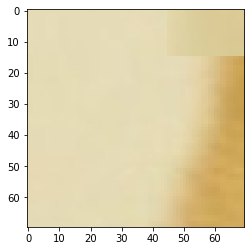

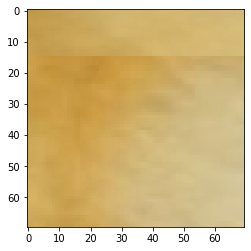

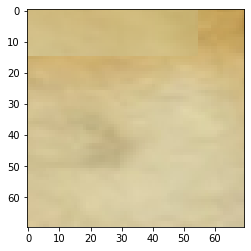

In [301]:
doge_rec = naive_reconstruction(doge_rectangle, 70)

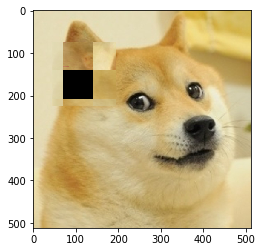

In [302]:
show_img(doge_rec)

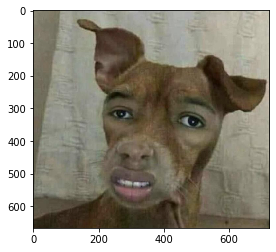

In [303]:
doge_weird = read_img("data/doge_weird.png")
show_img(doge_weird)

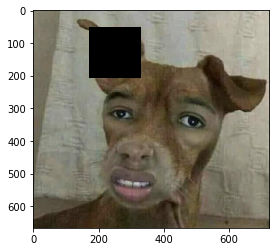

In [304]:
doge_weird_damaged = delete_rect(doge_weird, 130,250, 156,160)
show_img(doge_weird_damaged)

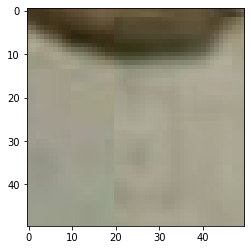

/Users/colinelacoux/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007682759795136773, tolerance: 0.007435228136815194
  positive)


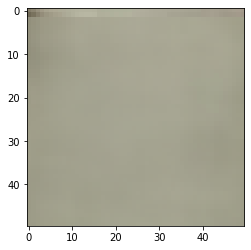

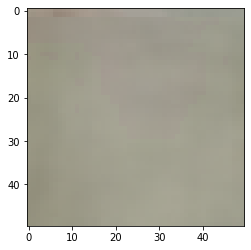

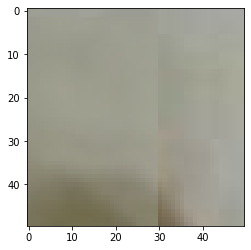

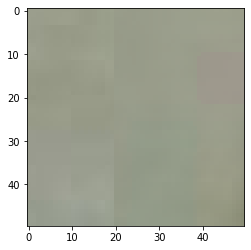

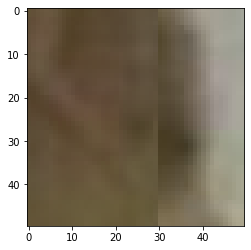

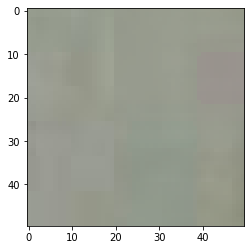

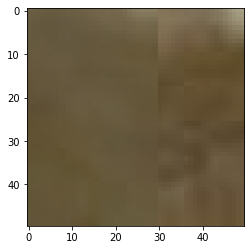

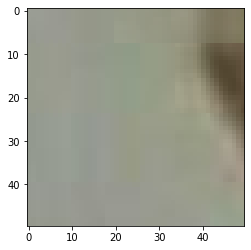

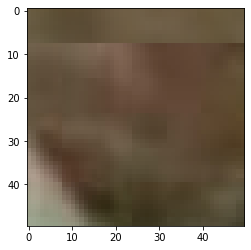

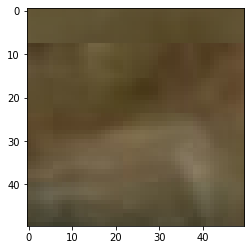

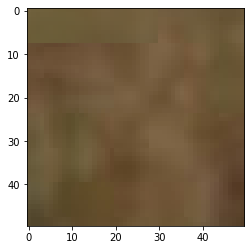

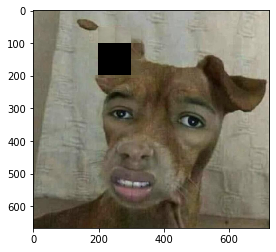

In [305]:
doge_weird_reconstructed = naive_reconstruction(doge_weird_damaged, 50)
show_img(doge_weird_reconstructed)

-> efficace pour reconstituer les textures mais si la zone est petite (< taille du découpage) 

-> pas suffisant si plusieurs textures dans la partie manquante (variation de couleurs)

    TODO : implémenter des statégie d'ordre de remplissage (voir article 3):
    - stratégie "onion peel" : commence par remplir en partant des bords (patch avant du bruit mais aussi des valeurs présents (+ d'un tiers par ex) mettre à jour le dict puis recommencer puis en remplissant au fur et à mesure vers le centre de l’image
    - implémenter heuristique proposée dans l'article 3

In [306]:
130 - 156/2

52.0

In [307]:
250 - 160/2

170.0

In [308]:
def dictionary_centered(img, x, y, m, n, h):
    dic = {}
    for i in range(x, x+m+h, h):
        for j in range(y, y+n+h, h):
            patch = get_patch(i, j, h, img)
            if miss_pixel(patch):
                dic[i,j] = patch
    return dic

In [309]:
def initialize_peel(img, h):
    missing_pixels = np.argwhere(img == -100)
    x = missing_pixels[0,0]
    y = missing_pixels[0,1]
    m =  missing_pixels[-1,0] -  missing_pixels[0,0]
    n =  missing_pixels[-1,1] -  missing_pixels[0,1]
    #print(x, y, m, n)
    dic = dictionary_centered(img, x, y, m, n, h)
    return dic

In [310]:
def onion_peel_reconstruction(img, h, alpha=0.005):
    img_rec = img.copy()
    dic = atoms_dictionary(img, h)
    stop = False
    while not stop :
        centered_dic = initialize_peel(img_rec, h)
        stop = True
        for (i,j), patch in centered_dic.items():
            if not empty_patch(patch):
                w, new_patch = learn_weigth(patch, dic, alpha)
                replace_patch(img_rec, new_patch, i, j, h)
            else:
                stop = False # un patch n'as pas pu être traité donc on continue
        show_img(img_rec)
        dic= atoms_dictionary(img_rec, h)
    return img_rec

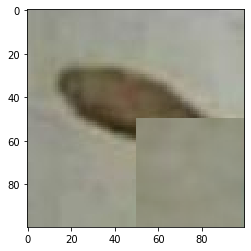

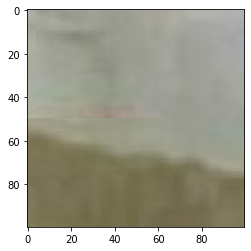

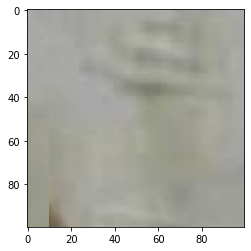

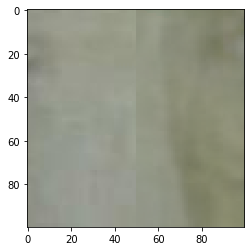

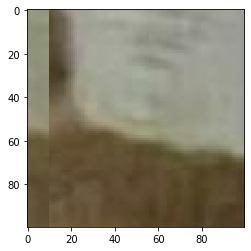

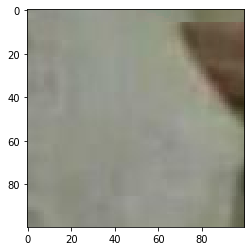

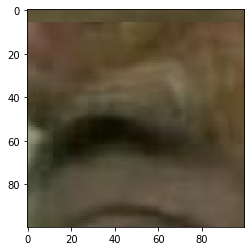

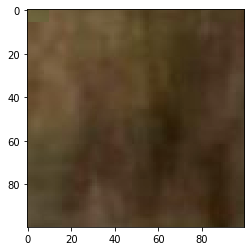

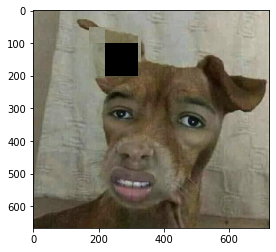

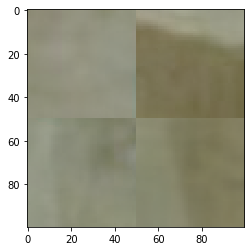

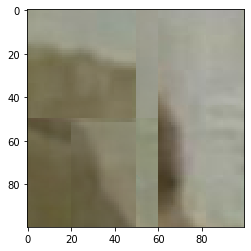

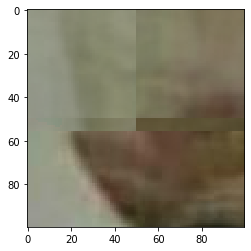

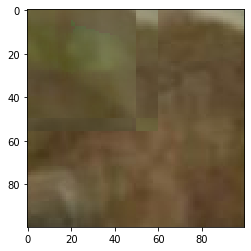

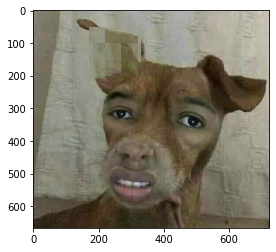

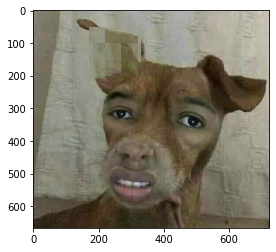

In [311]:
test = onion_peel_reconstruction(doge_weird_damaged, 100)
show_img(test)

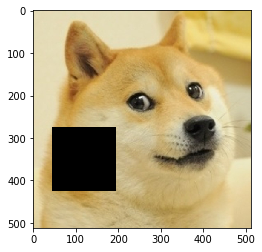

In [312]:
doge_rectangle = delete_rect(doge, 350,120, 150,150)

show_img(doge_rectangle)

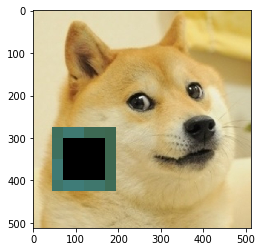

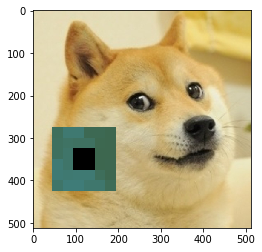

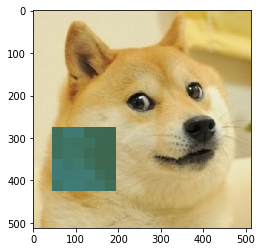

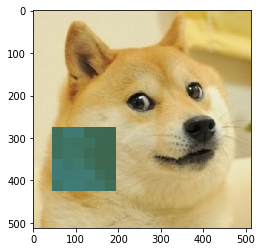

In [322]:
test2 = onion_peel_reconstruction(doge_rectangle, 50, alpha=0.5)
show_img(test2)

-> efficace sur grandes zone mais d'une même texture, bordures pas ouf

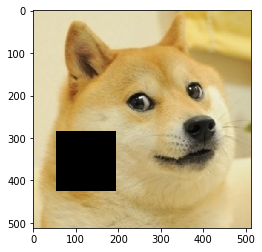

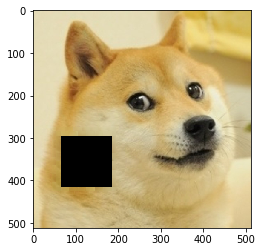

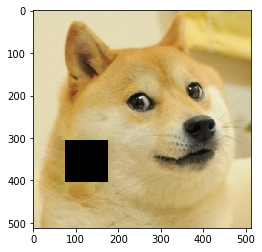

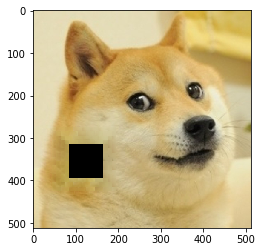

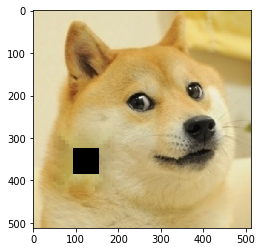

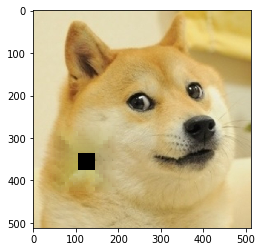

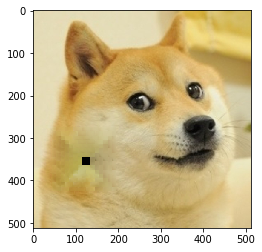

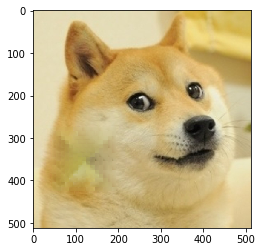

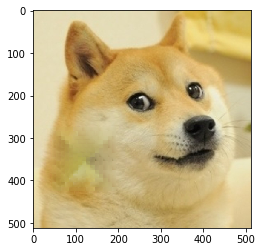

In [323]:
test3 = onion_peel_reconstruction(doge_rectangle, 20, alpha=0.005)
show_img(test3)

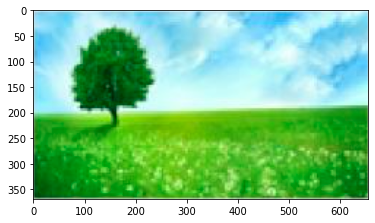

In [324]:
paysage = read_img("data/paysage.png")
show_img(paysage)

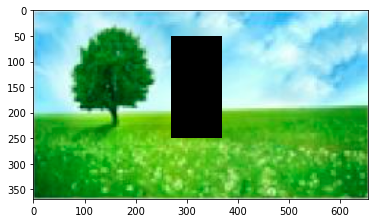

In [332]:
paysage_damaged = delete_rect(paysage, 150,320, 200,100)

show_img(paysage_damaged)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


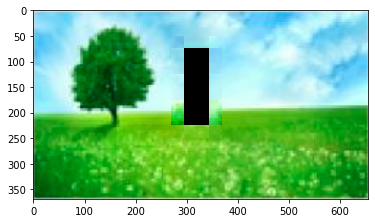

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


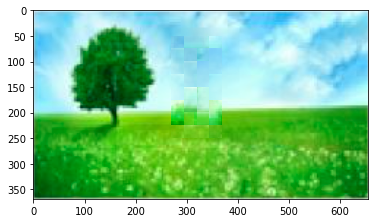

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


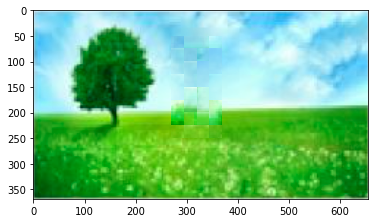

In [334]:
test4 = onion_peel_reconstruction(paysage_damaged, 50, alpha=0.005)
show_img(test4)

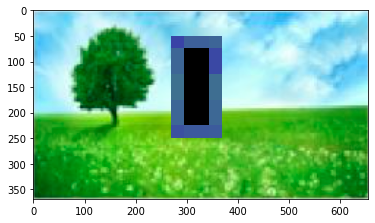

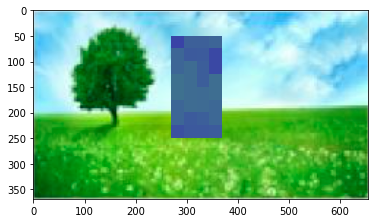

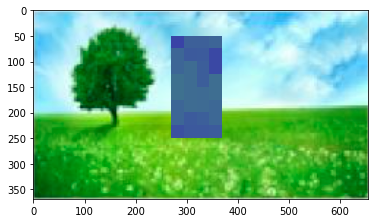

In [335]:
test5 = onion_peel_reconstruction(paysage_damaged, 50, alpha=1)
show_img(test5)

limite : plus alpha diminue, plus le nm d'itérations nécessaires est grand donc plus l'ago est long